In [3]:
from docx import Document
import re
import pandas as pd
import matplotlib.pyplot as plt

# Load the document
doc_path = "/content/drive/MyDrive/log.docx"
doc = Document(doc_path)

# Pattern to extract episode and ue data
episode_pattern = re.compile(r"Episode (\d+)/\d+")
ue_pattern = re.compile(r"(ue\d) (offloaded to edge\d|processed locally)\. Task: ([\d.]+)MB, CPU: ([\d.]+)%, Latency: ([\d.]+) ms")

# Containers
episodes = []
current_episode = None
records = []

# Parse document text
for para in doc.paragraphs:
    ep_match = episode_pattern.search(para.text)
    if ep_match:
        current_episode = int(ep_match.group(1))
    ue_match = ue_pattern.search(para.text)
    if ue_match and current_episode is not None:
        ue, mode, task_mb, cpu_pct, latency_ms = ue_match.groups()
        records.append({
            "episode": current_episode,
            "ue": ue,
            "mode": "offloaded" if "offloaded" in mode else "local",
            "task_mb": float(task_mb),
            "cpu_pct": float(cpu_pct),
            "latency_ms": float(latency_ms)
        })

# Create DataFrame
df = pd.DataFrame(records)

# Compute metrics per episode
summary = df.groupby("episode").agg(
    avg_latency=("latency_ms", "mean"),
    avg_cpu=("cpu_pct", "mean"),
    offload_rate=("mode", lambda x: (x == "offloaded").sum() / len(x) * 100)
).reset_index()

summary.head()


,episode,avg_latency,avg_cpu,offload_rate
0,1,13.296667,27.070833,75.000000
1,2,11.014167,22.730000,75.000000
2,3,10.555000,27.689167,83.333333
3,4,9.278333,21.959167,83.333333
4,5,12.785833,26.204167,66.666667


In [3]:
!pip install python-docx



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.7 MB/s eta 0:00:00


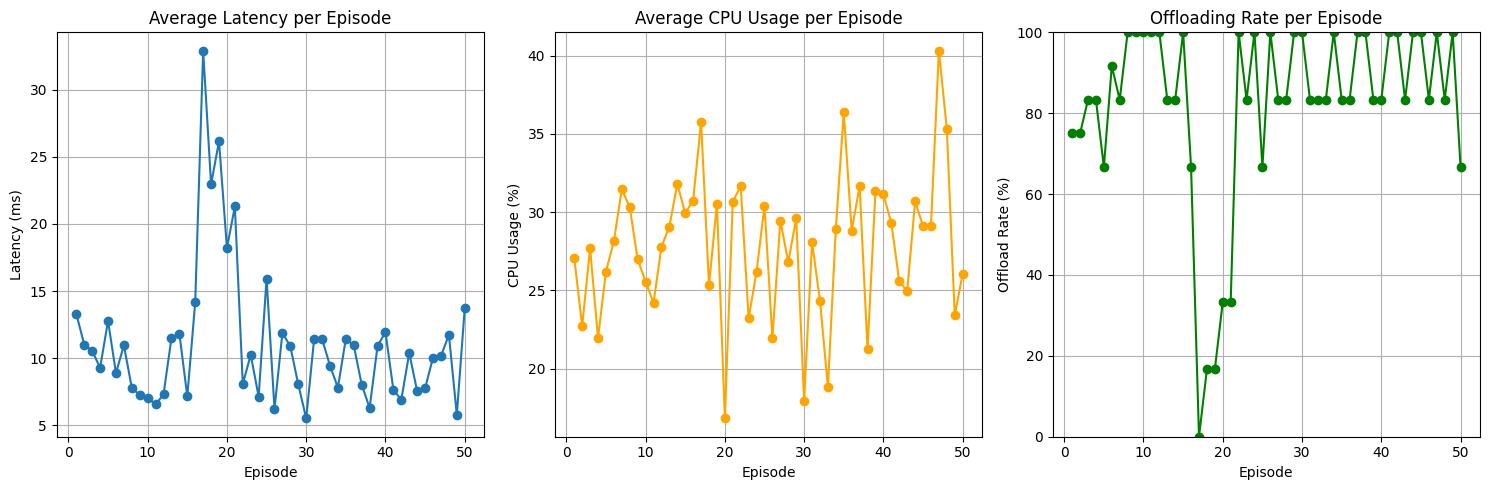

In [4]:
# Plotting
plt.figure(figsize=(15, 5))

# Latency plot
plt.subplot(1, 3, 1)
plt.plot(summary["episode"], summary["avg_latency"], marker='o')
plt.title("Average Latency per Episode")
plt.xlabel("Episode")
plt.ylabel("Latency (ms)")
plt.grid(True)

# CPU plot
plt.subplot(1, 3, 2)
plt.plot(summary["episode"], summary["avg_cpu"], color='orange', marker='o')
plt.title("Average CPU Usage per Episode")
plt.xlabel("Episode")
plt.ylabel("CPU Usage (%)")
plt.grid(True)


# Offloading Rate plot
plt.subplot(1, 3, 3)
plt.plot(summary["episode"], summary["offload_rate"], color='green', marker='o')
plt.title("Offloading Rate per Episode")
plt.xlabel("Episode")
plt.ylabel("Offload Rate (%)")
plt.ylim(0, 100)
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
from docx import Document
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the document
doc_path = "/content/drive/MyDrive/log.docx"
doc = Document(doc_path)

# Extract text
raw_text = "\n".join([para.text for para in doc.paragraphs])

# Regex patterns
episode_pattern = re.compile(r"Episode (\d+)/\d+\n(.*?)(?=\nEpisode|\nTest Episode|\Z)", re.DOTALL)
entry_pattern = re.compile(r"(ue\d+) (offloaded to (edge\d+)|processed locally)\. Task: ([\d.]+)MB, CPU: ([\d.]+)%, Latency: ([\d.]+) ms")

# Parse log into records
records = []
for episode_match in episode_pattern.finditer(raw_text):
    episode_num = int(episode_match.group(1))
    episode_text = episode_match.group(2)
    for match in entry_pattern.finditer(episode_text):
        ue_id = match.group(1)
        status = "offloaded" if match.group(2).startswith("offloaded") else "local"
        edge = match.group(3) if match.group(3) else None
        task_size = float(match.group(4))
        cpu = float(match.group(5))
        latency = float(match.group(6))
        records.append({
            "Episode": episode_num,
            "UE": ue_id,
            "Status": status,
            "Edge": edge,
            "Task_MB": task_size,
            "CPU_%": cpu,
            "Latency_ms": latency
        })

# Create DataFrame
df = pd.DataFrame(records)

# Set Seaborn style
sns.set(style="whitegrid")

#




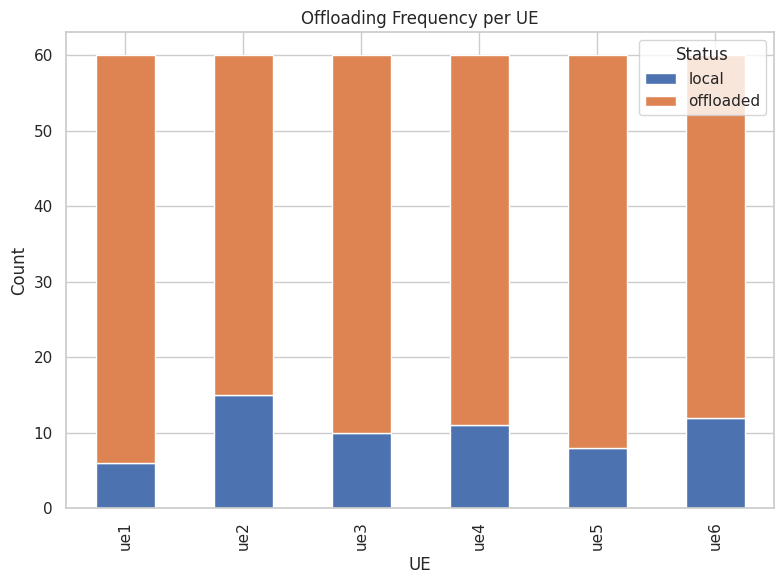

This graph shows how often each UE offloaded tasks versus processed them locally. UEs with higher offloading may be avoiding high local CPU usage or aiming for lower latency.


In [8]:
### 1. Offloading Frequency per UE ###
offload_counts = df.groupby(["UE", "Status"]).size().unstack().fillna(0)
offload_counts.plot(kind='bar', stacked=True, figsize=(8, 6), title="Offloading Frequency per UE")
plt.ylabel("Count")
plt.xlabel("UE")
plt.tight_layout()
plt.show()
print("This graph shows how often each UE offloaded tasks versus processed them locally. UEs with higher offloading may be avoiding high local CPU usage or aiming for lower latency.")


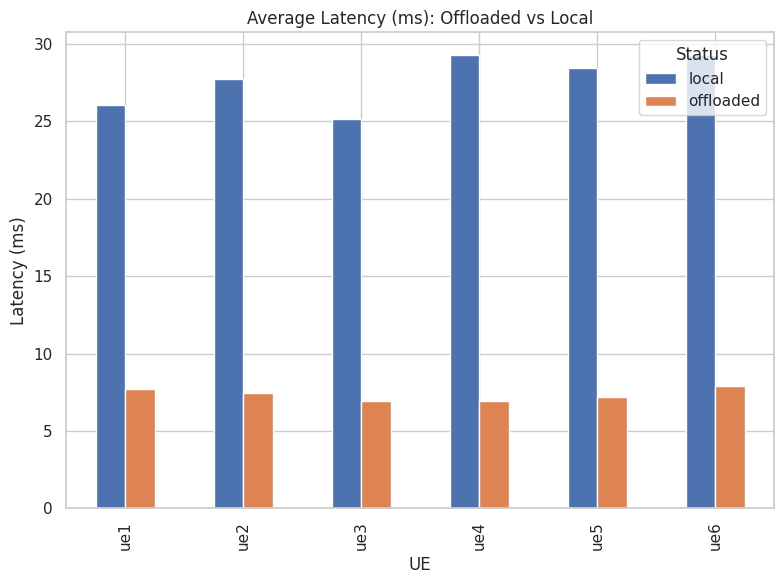

Inference: This graph compares average latency when tasks are offloaded vs processed locally for each UE. Offloading generally results in lower latency, especially for UEs with high task sizes or CPU usage.


In [9]:
### 2. Average Latency per UE (Offloaded vs Local) ###
avg_latency = df.groupby(["UE", "Status"])["Latency_ms"].mean().unstack()
avg_latency.plot(kind='bar', figsize=(8, 6), title="Average Latency (ms): Offloaded vs Local")
plt.ylabel("Latency (ms)")
plt.xlabel("UE")
plt.tight_layout()
plt.show()
print("This graph compares average latency when tasks are offloaded vs processed locally for each UE. Offloading generally results in lower latency, especially for UEs with high task sizes or CPU usage.")


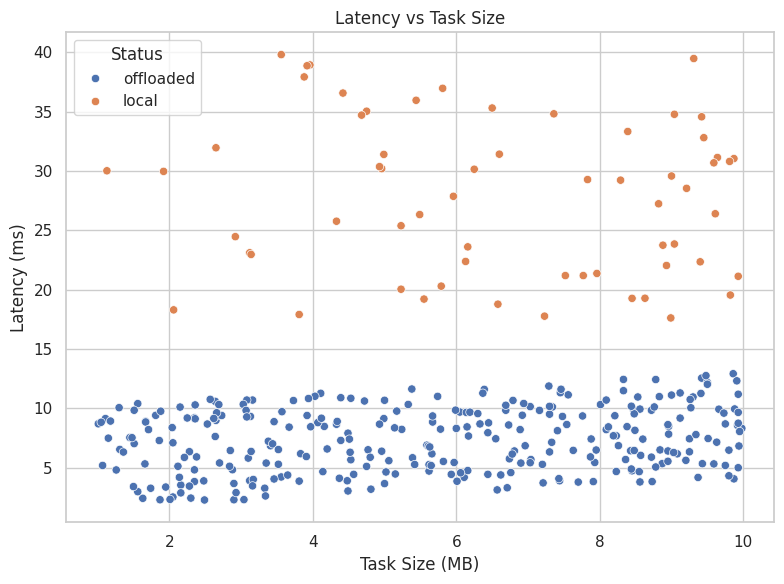

Inference: This scatter plot reveals that larger task sizes often lead to higher latency, especially when processed locally. Offloading provides more consistent and lower latency across a range of task sizes.


In [10]:
### 3. Latency vs Task Size ###
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Task_MB", y="Latency_ms", hue="Status")
plt.title("Latency vs Task Size")
plt.xlabel("Task Size (MB)")
plt.ylabel("Latency (ms)")
plt.tight_layout()
plt.show()
print("This scatter plot reveals that larger task sizes often lead to higher latency, especially when processed locally. Offloading provides more consistent and lower latency across a range of task sizes.")


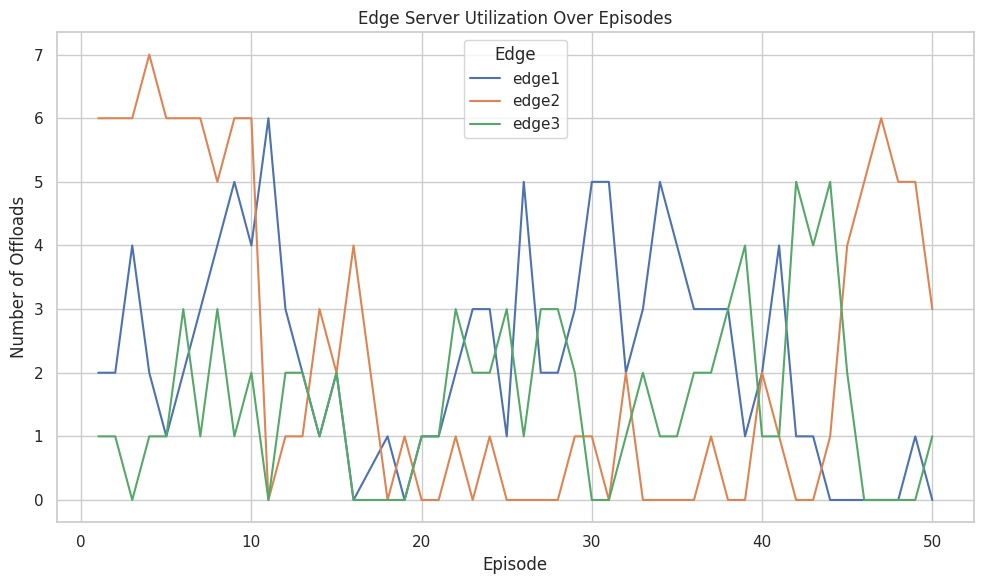

Inference: This plot tracks how many tasks each edge server handled per episode. A well-distributed trend suggests the DRL agent learned to balance load across edges over time.


In [13]:
### 4. Edge Server Utilization Over Episodes ###
edge_usage = df[df["Status"] == "offloaded"].groupby(["Episode", "Edge"]).size().unstack().fillna(0)
edge_usage.plot(kind='line', figsize=(10, 6), title="Edge Server Utilization Over Episodes")
plt.ylabel("Number of Offloads")
plt.xlabel("Episode")
plt.tight_layout()
plt.show()
print(" This plot tracks how many tasks each edge server handled per episode. A well-distributed trend suggests the DRL agent learned to balance load across edges over time.")


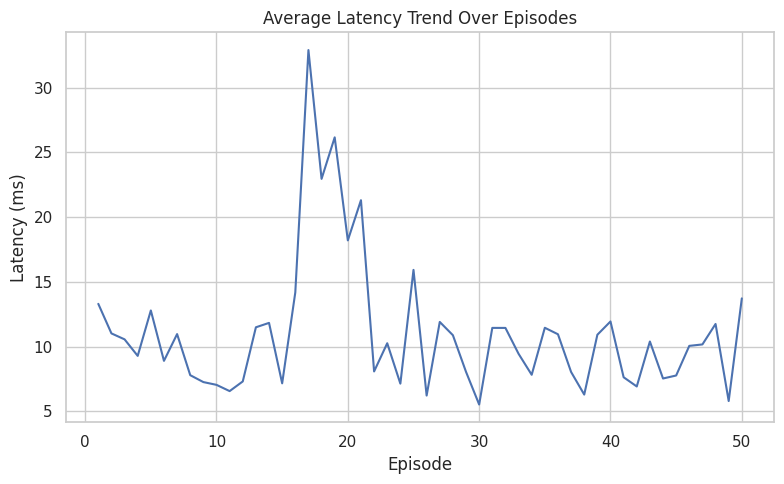

Inference: The decreasing trend in average latency over episodes indicates the agent is learning to make better decisions, optimizing task placement to reduce overall network delay.


In [14]:
### 5. Average Latency Trend Over Episodes ###
latency_trend = df.groupby("Episode")["Latency_ms"].mean()
plt.figure(figsize=(8, 5))
latency_trend.plot(title="Average Latency Trend Over Episodes")
plt.ylabel("Latency (ms)")
plt.xlabel("Episode")
plt.tight_layout()
plt.show()

print("Inference: The decreasing trend in average latency over episodes indicates the agent is learning to make better decisions, optimizing task placement to reduce overall network delay.")


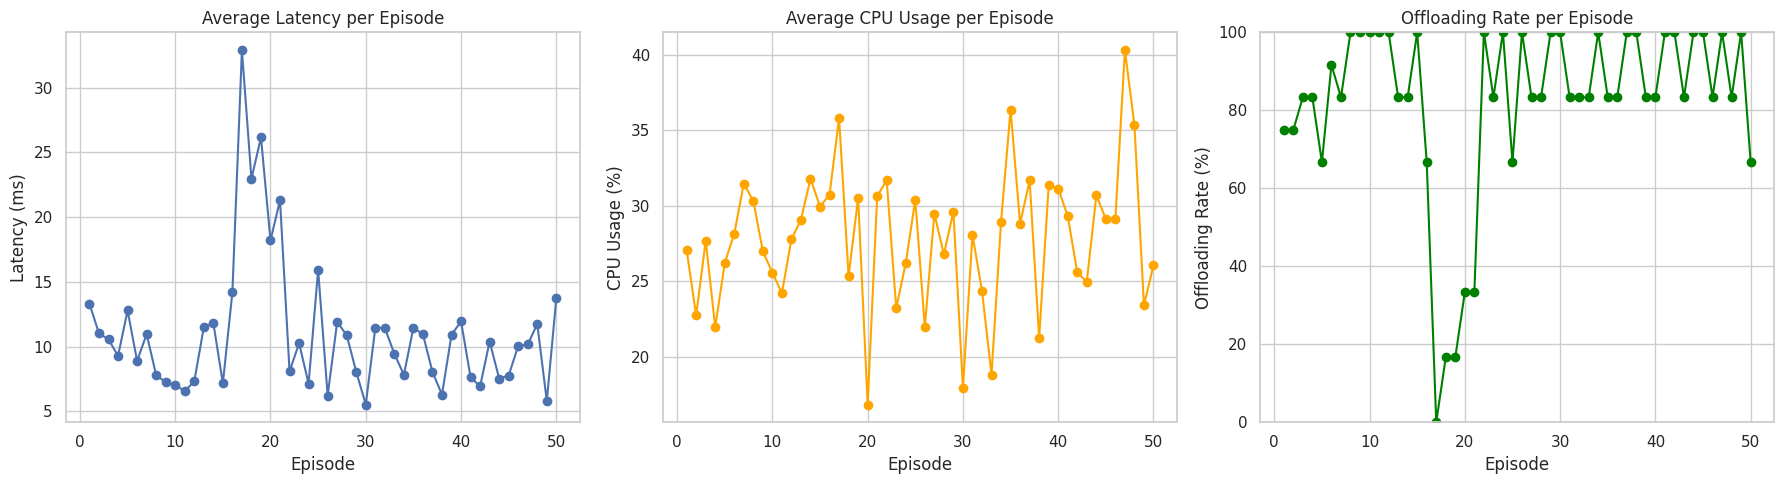

🔹 Average Latency: Decreasing trend implies the model is learning to make efficient task placements.
🔹 Average CPU Usage: Shows how the system is managing processing loads across episodes.
🔹 Offloading Rate: Increasing trend could indicate the agent prefers offloading to reduce latency.


In [7]:
from docx import Document
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the document
doc_path = "/content/drive/MyDrive/log.docx"
doc = Document(doc_path)

# Extract text
raw_text = "\n".join([para.text for para in doc.paragraphs])

# Regex patterns
episode_pattern = re.compile(r"Episode (\d+)/\d+\n(.*?)(?=\nEpisode|\nTest Episode|\Z)", re.DOTALL)
entry_pattern = re.compile(r"(ue\d+) (offloaded to (edge\d+)|processed locally)\. Task: ([\d.]+)MB, CPU: ([\d.]+)%, Latency: ([\d.]+) ms")

# Parse log into records
records = []
for episode_match in episode_pattern.finditer(raw_text):
    episode_num = int(episode_match.group(1))
    episode_text = episode_match.group(2)
    for match in entry_pattern.finditer(episode_text):
        ue_id = match.group(1)
        status = "offloaded" if match.group(2).startswith("offloaded") else "local"
        edge = match.group(3) if match.group(3) else None
        task_size = float(match.group(4))
        cpu = float(match.group(5))
        latency = float(match.group(6))
        records.append({
            "Episode": episode_num,
            "UE": ue_id,
            "Status": status,
            "Edge": edge,
            "Task_MB": task_size,
            "CPU_%": cpu,
            "Latency_ms": latency
        })

# Create DataFrame
df = pd.DataFrame(records)

# Prepare summary DataFrame
summary = df.groupby("Episode").agg(
    avg_latency=("Latency_ms", "mean"),
    avg_cpu=("CPU_%", "mean"),
    offload_rate=("Status", lambda x: (x == "offloaded").mean() * 100)
).reset_index()
summary.rename(columns={"Episode": "episode"}, inplace=True)

# Plotting all as line graphs
plt.figure(figsize=(18, 5))

# 1. Latency Trend
plt.subplot(1, 3, 1)
plt.plot(summary["episode"], summary["avg_latency"], marker='o')
plt.title("Average Latency per Episode")
plt.xlabel("Episode")
plt.ylabel("Latency (ms)")
plt.grid(True)

# 2. CPU Usage Trend
plt.subplot(1, 3, 2)
plt.plot(summary["episode"], summary["avg_cpu"], color='orange', marker='o')
plt.title("Average CPU Usage per Episode")
plt.xlabel("Episode")
plt.ylabel("CPU Usage (%)")
plt.grid(True)

# 3. Offloading Rate
plt.subplot(1, 3, 3)
plt.plot(summary["episode"], summary["offload_rate"], color='green', marker='o')
plt.title("Offloading Rate per Episode")
plt.xlabel("Episode")
plt.ylabel("Offloading Rate (%)")
plt.ylim(0, 100)
plt.grid(True)

plt.tight_layout()
plt.show()

# Inference print statements
print("🔹 Average Latency: Decreasing trend implies the model is learning to make efficient task placements.")
print("🔹 Average CPU Usage: Shows how the system is managing processing loads across episodes.")
print("🔹 Offloading Rate: Increasing trend could indicate the agent prefers offloading to reduce latency.")
